In [1]:
import spikeinterface.full as si
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import settings as settings
from scipy import signal
import math

from astropy.convolution import convolve, Gaussian1DKernel



In [2]:
def calculate_firing_probability(convolved_spikes):
    firing_rate = get_rolling_sum(convolved_spikes, 2)
    return (firing_rate*1000)/2 # convert to Hz

def moving_sum(array, window):
    ret = np.cumsum(array, dtype=float)
    ret[window:] = ret[window:] - ret[:-window]
    return ret[window:] / window

def get_rolling_sum(array_in, window):
    if window > (len(array_in) / 3) - 1:
        print('Window is too big, plot cannot be made.')
    inner_part_result = moving_sum(array_in, window)
    edges = np.append(array_in[-2 * window:], array_in[: 2 * window])
    edges_result = moving_sum(edges, window)
    end = edges_result[window:math.floor(len(edges_result)/2)]
    beginning = edges_result[math.floor(len(edges_result)/2):-window]
    array_out = np.hstack((beginning, inner_part_result, end))
    return array_out

def extract_instantaneous_firing_rate(cluster_data):
    firing_times=cluster_data.firing_times/30 # convert from samples to ms
    if isinstance(firing_times, pd.Series):
        firing_times = firing_times.iloc[0]
    bins = np.arange(0,np.max(firing_times), 1)
    instantaneous_firing_rate = np.histogram(firing_times, bins=bins, range=(0, max(bins)))[0]

    gauss_kernel = Gaussian1DKernel(5) # sigma = 200ms
    smoothened_instantaneous_firing_rate = convolve(instantaneous_firing_rate, gauss_kernel)
    return smoothened_instantaneous_firing_rate

def calculate_spectral_density(firing_rate):
    f, Pxx_den = signal.welch(firing_rate, fs=1000, nperseg=10000, scaling='spectrum')
    Pxx_den = Pxx_den*f
    return f, Pxx_den


##### this time were going to bin and average over a specific area of the probe  to get unit-location specific theta visuals 

/tmp/ipykernel_9559/4214801518.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis")
/tmp/ipykernel_9559/4214801518.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis")
/tmp/ipykernel_9559/4214801518.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("viridis")
/tmp/ipykernel_9559/4214801518.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and 

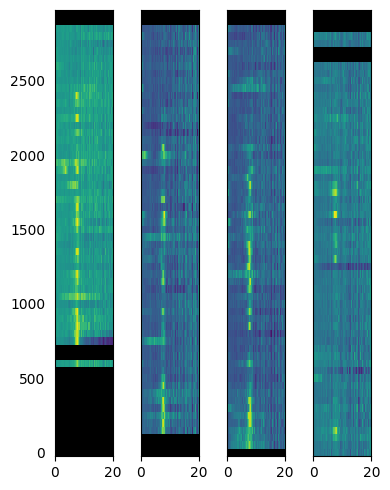

In [3]:
project_path = "/mnt/datastore/Harry/Cohort11_april2024/"
derivative_path = "/mnt/datastore/Harry/Cohort11_april2024/derivatives/"

# get sorting analyzer and unit locations
vr_session_base_names = ["M21_D26_2024-05-28_17-04-41_VR1"]
vr_session_base_names = ["M21_D26_2024-05-28_17-04-41_VR1", "M21_D24_2024-05-26_16-35-19_VR1", "M21_D23_2024-05-25_16-54-12_VR1", "M21_D25_2024-05-27_16-00-30_VR1"]

fig, axs = plt.subplots(1, 4, figsize=(4, 5), sharey=True)

power_spectras_all = []
for i, vr_name in enumerate(vr_session_base_names):
    mouse = vr_name.split("_")[0]
    day = vr_name.split("_")[1]
    recording_path =  f"{project_path}vr/{vr_name}"
    vr_path = f"{derivative_path}{mouse}/{day}/vr/{vr_name}/processed/kilosort4/spikes.pkl"
    sorting_analyzer_path = f"{derivative_path}{mouse}/{day}/ephys/sorting_analyzer"
    spike_data_vr = pd.read_pickle(vr_path)

    sorting_analyzer = si.load_sorting_analyzer(sorting_analyzer_path)
    ulc = sorting_analyzer.get_extension("unit_locations")
    unit_locations = ulc.get_data(outputs="by_unit")

    spike_data_vr['unit_location_x'] = (spike_data_vr.index.map(lambda unit: unit_locations[unit][0])*-1)+750+40
    spike_data_vr['unit_location_y'] = spike_data_vr.index.map(lambda unit: unit_locations[unit][1])
    spike_data_vr['unit_location_z'] = spike_data_vr.index.map(lambda unit: unit_locations[unit][2])
    
    spike_data_vr = spike_data_vr[(spike_data_vr["snr"] > 1) & 
                                  (spike_data_vr["mean_firing_rate"] > 0.5) & 
                                  (spike_data_vr["rp_contamination"] < 0.9)]

    # calcuate power spectra for all clusters and save the y positions to bin by later
    power_spectras = []
    y_poses = []
    for cluster_id in spike_data_vr.cluster_id:
        cluster_data = spike_data_vr[spike_data_vr["cluster_id"] == cluster_id]
        if len(cluster_data["firing_times"].iloc[0])>0:
            instantaneous_firing_rate = extract_instantaneous_firing_rate(cluster_data)
            firing_rate = calculate_firing_probability(instantaneous_firing_rate)
            f, Pxx_den = calculate_spectral_density(firing_rate)
            power_spectras.append(Pxx_den/np.nanmax(Pxx_den))
            y_poses.append(cluster_data["unit_location_y"].iloc[0])
    power_spectras = np.array(power_spectras)
    y_poses = np.array(y_poses)

    # make a reference signal from which to subtract
    subtract_ref = True 
    reference_data = cluster_data.copy()
    firing_times = np.random.randint(low=0, high=int(1800*30000), size=int(1800*10))
    fdfdfdf = []
    for fgf in range(1):
        fdfdfdf.append(firing_times)
    reference_data["firing_times"] = fdfdfdf  
    instantaneous_firing_rate = extract_instantaneous_firing_rate(reference_data)
    firing_rate = calculate_firing_probability(instantaneous_firing_rate)
    f, Pxx_den_ref = calculate_spectral_density(firing_rate)
    Pxx_den_ref = Pxx_den_ref/np.nanmax(Pxx_den_ref)

    # construct power spectra as a function of location bin
    step = 50 # um
    locations = np.arange(0, 3000, step=step)
    power_spectras_by_location_bin = []
    for loc in locations:
        f_by_bin = np.zeros(len(f)); f_by_bin[:] = np.nan
        if len(power_spectras[(y_poses>loc) & (y_poses<(loc+step))])>0:
            f_by_bin = np.nanmax(power_spectras[(y_poses>loc) & (y_poses<(loc+step))], axis=0)
            if subtract_ref:
                f_by_bin -= Pxx_den_ref 
        power_spectras_by_location_bin.append(f_by_bin)

    # plot power spectra by bin
    X, Y = np.meshgrid(f, locations)
    cmap = plt.cm.get_cmap("viridis")
    cmap.set_bad("black")
    axs[i].pcolormesh(X, Y, power_spectras_by_location_bin, cmap=cmap, shading="auto")
    axs[i].tick_params(axis='y', which='both', left=False, right=False)
    axs[i].set_xlim(([0,20]))

    power_spectras_all.append(power_spectras)
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/datastore/Harry/Cohort11_april2024/derivatives/M20/D25/vr/M20_D25_2024-05-27_14-24-21_VR1M20_D23_2024-05-25_14-54-34_VR1/processed/kilosort4/spikes.pkl'

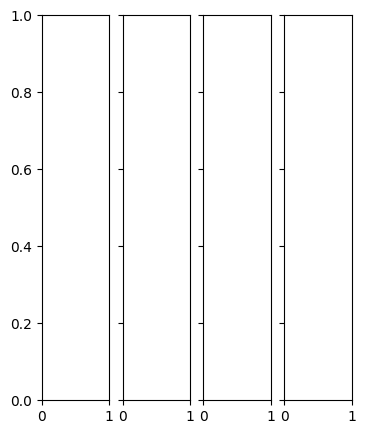

In [6]:
project_path = "/mnt/datastore/Harry/Cohort11_april2024/"
derivative_path = "/mnt/datastore/Harry/Cohort11_april2024/derivatives/"

# get sorting analyzer and unit locations
vr_session_base_names = ["M20_D25_2024-05-27_14-24-21_VR1",
                         "M20_D23_2024-05-25_14-54-34_VR1",
                         "M20_D24_2024-05-26_14-49-32_VR1",
                         "M20_D26_2024-05-28_15-18-55_VR1"]
#vr_session_base_names = ["M20_D23_2024-05-25_14-54-34_VR1"]
fig, axs = plt.subplots(1, 4, figsize=(4, 5), sharey=True)

power_spectras_all = []
for i, vr_name in enumerate(vr_session_base_names):
    mouse = vr_name.split("_")[0]
    day = vr_name.split("_")[1]
    recording_path =  f"{project_path}vr/{vr_name}"
    vr_path = f"{derivative_path}{mouse}/{day}/vr/{vr_name}/processed/kilosort4/spikes.pkl"
    sorting_analyzer_path = f"{derivative_path}{mouse}/{day}/ephys/sorting_analyzer"
    spike_data_vr = pd.read_pickle(vr_path)

    sorting_analyzer = si.load_sorting_analyzer(sorting_analyzer_path)
    ulc = sorting_analyzer.get_extension("unit_locations")
    unit_locations = ulc.get_data(outputs="by_unit")

    spike_data_vr['unit_location_x'] = spike_data_vr.index.map(lambda unit: unit_locations[unit][0])
    spike_data_vr['unit_location_y'] = spike_data_vr.index.map(lambda unit: unit_locations[unit][1])
    spike_data_vr['unit_location_z'] = spike_data_vr.index.map(lambda unit: unit_locations[unit][2])
    
    spike_data_vr = spike_data_vr[(spike_data_vr["snr"] > 1) & 
                                  (spike_data_vr["mean_firing_rate"] > 0.5) & 
                                  (spike_data_vr["rp_contamination"] < 0.9)]
    
    # calcuate power spectra for all clusters and save the y positions to bin by later
    power_spectras = []
    y_poses = []
    for cluster_id in spike_data_vr.cluster_id:
        cluster_data = spike_data_vr[spike_data_vr["cluster_id"] == cluster_id]
        if len(cluster_data["firing_times"].iloc[0])>0:
            instantaneous_firing_rate = extract_instantaneous_firing_rate(cluster_data)
            firing_rate = calculate_firing_probability(instantaneous_firing_rate)
            f, Pxx_den = calculate_spectral_density(firing_rate)
            power_spectras.append(Pxx_den/np.nanmax(Pxx_den))
            y_poses.append(cluster_data["unit_location_y"].iloc[0])
    power_spectras = np.array(power_spectras)
    y_poses = np.array(y_poses)
    
    # make a reference signal from which to subtract
    subtract_ref = True 
    reference_data = cluster_data.copy()
    firing_times = np.random.randint(low=0, high=int(1800*30000), size=int(1800*10))
    fdfdfdf = []
    for ffdf in range(1):
        fdfdfdf.append(firing_times)
    reference_data["firing_times"] = fdfdfdf  
    instantaneous_firing_rate = extract_instantaneous_firing_rate(reference_data)
    firing_rate = calculate_firing_probability(instantaneous_firing_rate)
    f, Pxx_den_ref = calculate_spectral_density(firing_rate)
    Pxx_den_ref = Pxx_den_ref/np.nanmax(Pxx_den_ref)

    # construct power spectra as a function of location bin
    step = 50 # um
    locations = np.arange(0, 3000, step=step)
    power_spectras_by_location_bin = []
    for loc in locations:
        f_by_bin = np.zeros(len(f)); f_by_bin[:] = np.nan
        if len(power_spectras[(y_poses>loc) & (y_poses<(loc+step))])>0:
            f_by_bin = np.nanmax(power_spectras[(y_poses>loc) & (y_poses<(loc+step))], axis=0)
            if subtract_ref:
                f_by_bin -= Pxx_den_ref

        power_spectras_by_location_bin.append(f_by_bin)

    # plot power spectra by bin
    X, Y = np.meshgrid(f, locations)
    cmap = plt.cm.get_cmap("viridis")
    cmap.set_bad("black")
    axs[i].pcolormesh(X, Y, power_spectras_by_location_bin, cmap=cmap, shading="auto")
    axs[i].tick_params(axis='y', which='both', left=False, right=False)
    axs[i].set_xlim(([0,20]))

    power_spectras_all.append(power_spectras)
plt.tight_layout()
plt.show()


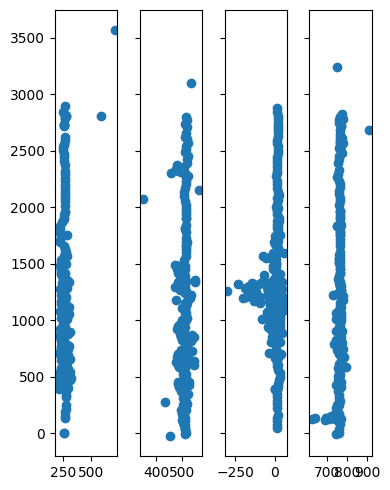

In [5]:
project_path = "/mnt/datastore/Harry/Cohort11_april2024/"
derivative_path = "/mnt/datastore/Harry/Cohort11_april2024/derivatives/"

# get sorting analyzer and unit locations
vr_session_base_names = [
                      "M20_D23_2024-05-25_14-54-34_VR1",
                      "M20_D24_2024-05-26_14-49-32_VR1", 
                      "M20_D25_2024-05-27_14-24-21_VR1",
                      "M20_D26_2024-05-28_15-18-55_VR1"]
fig, axs = plt.subplots(1, 4, figsize=(4, 5), sharey=True)

power_spectras_all = []
for i, vr_name in enumerate(vr_session_base_names):
    mouse = vr_name.split("_")[0]
    day = vr_name.split("_")[1]
    recording_path =  f"{project_path}vr/{vr_name}"
    vr_path = f"{derivative_path}{mouse}/{day}/vr/{vr_name}/processed/kilosort4/spikes.pkl"
    sorting_analyzer_path = f"{derivative_path}{mouse}/{day}/ephys/sorting_analyzer"
    spike_data_vr = pd.read_pickle(vr_path)

    sorting_analyzer = si.load_sorting_analyzer(sorting_analyzer_path)
    ulc = sorting_analyzer.get_extension("unit_locations")
    unit_locations = ulc.get_data(outputs="by_unit")

    spike_data_vr['unit_location_x'] = spike_data_vr.index.map(lambda unit: unit_locations[unit][0])
    spike_data_vr['unit_location_y'] = spike_data_vr.index.map(lambda unit: unit_locations[unit][1])
    spike_data_vr['unit_location_z'] = spike_data_vr.index.map(lambda unit: unit_locations[unit][2])
    axs[i].scatter(spike_data_vr['unit_location_x'], spike_data_vr['unit_location_y'])

plt.tight_layout()
plt.show()
